<h1>Промежуточная аттестация</h1>
<b><p style="color:#333;">Цель задания:<br>
Исследовать различные методы бустинга и бэггинга на данных и выбрать лучшую
модель с учетом точности прогнозирования и обобщающей способности на новых
данных.</p>

<h1>Подключаем библиотеки</h1>

In [1]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.3 MB/s eta 0:00:00


In [2]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.5 MB/s eta 0:00:00


In [3]:
from category_encoders import TargetEncoder

In [82]:
import numpy as np
import pandas as pd


from sklearn.datasets import make_classification
from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier



from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from mlxtend.plotting import plot_decision_regions  # требуется установка mlxtend

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tqdm
import zipfile

#Описание датасета
<b>Классификация пульсаров для предсказания класса</b><br>
<b>17898 записей</b><br>
Данные могут быть полезны для моделей прогнозирования классификации</b><br>.
<b>СТОЛБЦЫ</b>: <br>.
на основе интегрированного профиля наблюдения<br>.
•	<b>Mean_Integrated</b>: среднее значение наблюдений<br>.
•	<b>SD</b>: стандартное отклонение наблюдений<br>.
•	<b>ЕК</b>: Избыточный эксцесс наблюдений<br>.
•	<b>Асимметрия</b>: в теории вероятностей и статистике асимметрия — это мера асимметрии распределения вероятностей <br>.действительнозначной случайной величины относительно ее среднего значения. Асимметрия наблюдений. <br>.
•	<b>Mean _ DMSNR _ Curve</b>: Среднее значение DM SNR CURVE наблюдений<br>.
•	<b>SD _ DMSNR _ Curve</b>: стандартное отклонение DM SNR CURVE наблюдений<br>.
•	<b>EK _ DMSNR _ Кривая: </b> Избыточный эксцесс DM SNR КРИВАЯ наблюдений<br>.
•	<b>Асимметрия _ DMSNR _ Кривая</b>: асимметрия DM SNR CURVE наблюдений<br>.
•	<b>Класс: Класс 0 - 1<br>.
ЧТО ТАКОЕ КРИВАЯ DM SNR: <br>.
Радиоволны, излучаемые пульсарами, достигают Земли после прохождения больших расстояний в пространстве, заполненном свободными электронами. Важным моментом является то, что пульсары излучают в широком диапазоне частот, и величина, на которую электроны замедляют волну, зависит от частоты. Волны с более высокой частотой засеиваются меньше по сравнению с волнами с более высокой частотой. Это означает рассеивание. <br>.
ЦЕЛЬ: <br>.
Класс<br>.
0 -- это не пульсар<br>.
1 – это пульсар<br>.
https://www.kaggle.com/competitions/playground-series-s3e10/data?select=train.csv


<h1>Грузим датасет</h1>

In [83]:
# Классификация пульсаров
#https://www.kaggle.com/competitions/playground-series-s3e10/data?select=train.csv
# from sklearn import datasets
data = pd.read_csv('train_s3e10.csv')
data.tail(3)


,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
117561,117561,119.757812,49.980013,0.064402,-0.270822,3.877926,19.788559,6.959740,56.367789,0
117562,117562,105.789062,46.986595,0.441426,0.372466,2.097826,17.170612,9.442445,99.074539,0
117563,117563,113.515625,50.935956,0.031517,-0.443831,23.290970,62.006842,2.386364,4.001859,0


In [84]:
X = data.drop(columns=['id','Class'])
y = data['Class']

<h1>EDA</h1>

In [85]:
# Размер датасета
print(f"В датасете: {X.shape[0]} строк")

# Information about columns and data types
print(f"\n В датасете {X.shape[1]} столбцов, из них :")
print(X.dtypes.value_counts())

В датасете: 117564 строк

 В датасете 8 столбцов, из них :
float64    8
dtype: int64


In [8]:
X.dtypes

Mean_Integrated         float64
SD                      float64
EK                      float64
Skewness                float64
Mean_DMSNR_Curve        float64
SD_DMSNR_Curve          float64
EK_DMSNR_Curve          float64
Skewness_DMSNR_Curve    float64
dtype: object

In [9]:
print("\n Статистика по столбцам:")
X.describe().T


 Статистика по столбцам:


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,117564.0,111.248300,24.906474,6.054688,104.546875,116.664062,126.296875,189.367188
SD,117564.0,46.713535,6.102941,24.783273,43.443390,47.478932,50.862718,93.602933
EK,117564.0,0.503498,1.127093,-1.730782,0.049761,0.186498,0.395620,7.879628
Skewness,117564.0,1.886385,6.515466,-1.791886,-0.188956,0.091720,0.691613,65.385974
Mean_DMSNR_Curve,117564.0,11.962921,26.719946,0.213211,2.090301,2.808528,4.122910,217.371238
SD_DMSNR_Curve,117564.0,26.190678,20.041937,7.370432,14.955405,18.164924,24.732218,109.890785
EK_DMSNR_Curve,117564.0,8.037488,3.840980,-2.597872,6.742911,8.442883,10.003237,34.539844
Skewness_DMSNR_Curve,117564.0,93.881076,79.962110,-1.976976,49.409136,83.421375,122.093290,1191.000837


<b>Построим графики по каждому столбцу, чтобы увидеть есть ли выбросы</b>

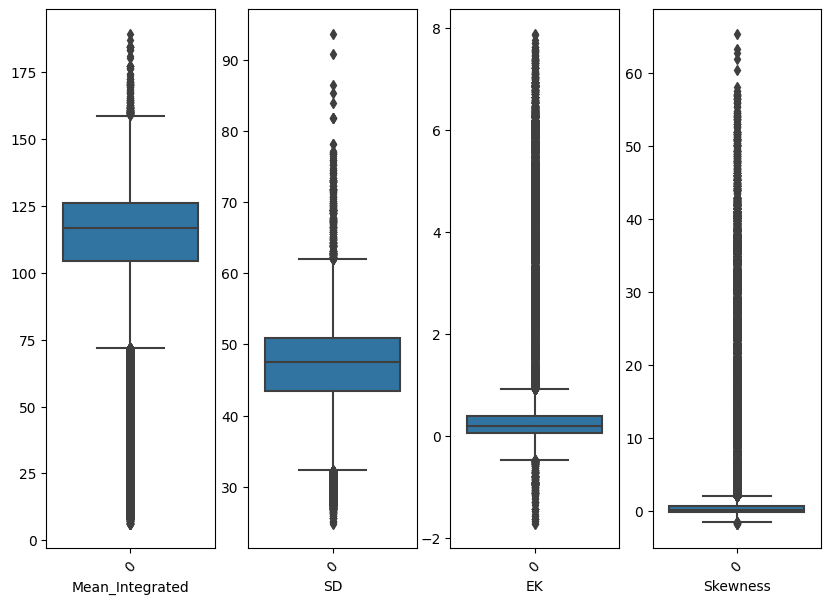

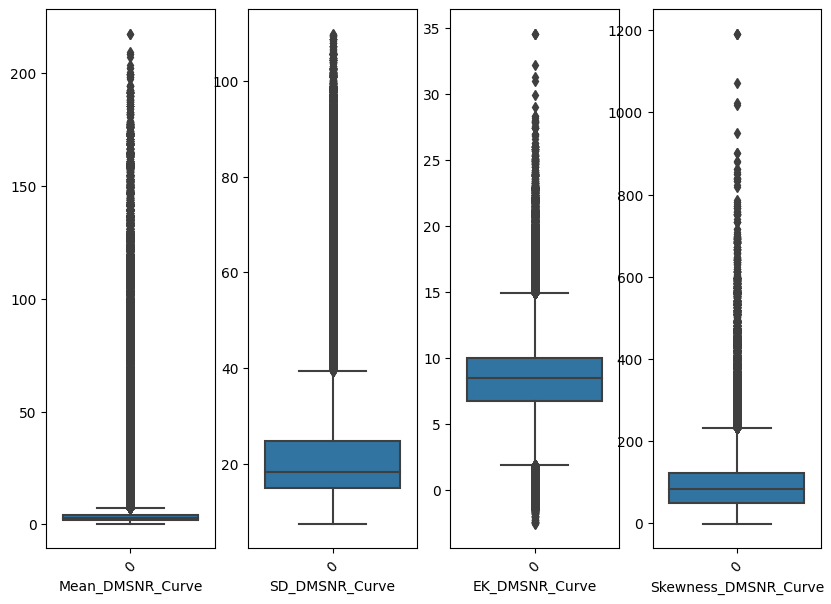

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Делим 8 столбцов на 2 окна по 4 графика в каждом окне
num_windows = 2
num_plots_per_window = 4

# Разделяем столбцы на группы по 5
groups = [X.columns[i:i+num_plots_per_window] for i in range(0, len(X.columns), num_plots_per_window)]

# Создаем каждое окно с 5 графиками
for group in groups:
    plt.figure(figsize=(10, 7))

    # Строим графики для каждого столбца в текущей группе
    for i, column in enumerate(group):
        plt.subplot(1, len(group), i + 1)
        sns.boxplot(data=X[column])
        plt.xticks(rotation=45)
        plt.xlabel(column)

    # Отображаем текущее окно
    plt.show()

<h1>Вывод</h1>
<h2>Выбросы присутствуют по большинству столбцов. Прям что то страшное.</h2>

Посмотрим сколько это в процентах

In [11]:
def analyze_outliers(df, col):
  # найдем с помощью IQR
  Q3 = np.quantile(df[col], 0.75, axis=0)
  Q1 = np.quantile(df[col], 0.25, axis=0)
  IQR = Q3 - Q1
  upper = round(Q3 + 1.5 * IQR, 2)
  lower = round(Q1 - 1.5 * IQR, 2)
  if round(Q1 - 1.5 * IQR, 2)<0:
    lower = 0
  print('____________________________________________________________________')
  print(f'интервал фактических значений для переменной {col} от {round(df[col].min(),2)} до {round(df[col].max(),2)}')
  print(f'интервал нормальных значений для переменной {col} от {lower} до {upper}')

  print(f'переменная {col} содержит аномальных значений : {round(df[(df[col]>upper)| (df[col]<lower)].shape[0]/df.shape[0]*100, 2)}%')

  if df[(df[col] == 0)].shape[0]>0:
    print(f'переменная {col} содержит нулевые значения {round(df[(df[col] == 0)].shape[0]/df.shape[0]*100, 2)}%')

  return lower, upper

In [ ]:
for col in X.columns:
    analyze_outliers(X, col)

____________________________________________________________________
интервал фактических значений для переменной Mean_Integrated от 6.05 до 189.37
интервал нормальных значений для переменной Mean_Integrated от 71.92 до 158.92
переменная Mean_Integrated содержит аномальных значений : 7.77%
____________________________________________________________________
интервал фактических значений для переменной SD от 24.78 до 93.6
интервал нормальных значений для переменной SD от 32.31 до 61.99
переменная SD содержит аномальных значений : 3.2%
____________________________________________________________________
интервал фактических значений для переменной EK от -1.73 до 7.88
интервал нормальных значений для переменной EK от 0 до 0.91
переменная EK содержит аномальных значений : 26.72%
____________________________________________________________________
интервал фактических значений для переменной Skewness от -1.79 до 65.39
интервал нормальных значений для переменной Skewness от 0 до 2.01
перемен

#Вывод <br>
Очень большой процент выбросов. Для некоторых столбцов процент выбросов больше 50.<br>
Мне кажется, что заменять чем либо (хоть чем) такой большой процент данных это равносильно существенному искажению информации. Поэтому ничего делать с выбросами пока не стану.

<h1>Теперь посмотрим есть ли пропуски в данных</h1>

In [12]:
# Вычисляем количество пропусков по каждому столбцу
missing_values = X.isnull().sum()

# Выводим количество пропусков по каждому столбцу
for column, missing_count in missing_values.items():
    print(f"Количество пропусков в столбце {column}: {missing_count}")

Количество пропусков в столбце Mean_Integrated: 0
Количество пропусков в столбце SD: 0
Количество пропусков в столбце EK: 0
Количество пропусков в столбце Skewness: 0
Количество пропусков в столбце Mean_DMSNR_Curve: 0
Количество пропусков в столбце SD_DMSNR_Curve: 0
Количество пропусков в столбце EK_DMSNR_Curve: 0
Количество пропусков в столбце Skewness_DMSNR_Curve: 0


<h1>Вывод: пропусков в данных нет</h1>

<h1>Посмотрим, есть ли нулевые значения параметров</h1> поскольку это могут быть скрытые пропуски

In [13]:
# Вычисляем количество нулевых значений по каждому столбцу
zero_values = X.eq(0).sum()

# Выводим количество нулевых значений по каждому столбцу
for column, zero_count in zero_values.items():
    print(f"Количество нулевых значений в столбце {column}: {zero_count}")

Количество нулевых значений в столбце Mean_Integrated: 0
Количество нулевых значений в столбце SD: 0
Количество нулевых значений в столбце EK: 0
Количество нулевых значений в столбце Skewness: 0
Количество нулевых значений в столбце Mean_DMSNR_Curve: 0
Количество нулевых значений в столбце SD_DMSNR_Curve: 0
Количество нулевых значений в столбце EK_DMSNR_Curve: 0
Количество нулевых значений в столбце Skewness_DMSNR_Curve: 0


<h1>Вывод</h1> <b>Нулевые значения отсутствуют</b>

<h1>Посмотрим на распределение целевой переменной</h1>


In [14]:
# распределение целевой
print("\nTarget Class Distribution:")
pd.Series(y).value_counts()


Target Class Distribution:


0    106597
1     10967
Name: Class, dtype: int64

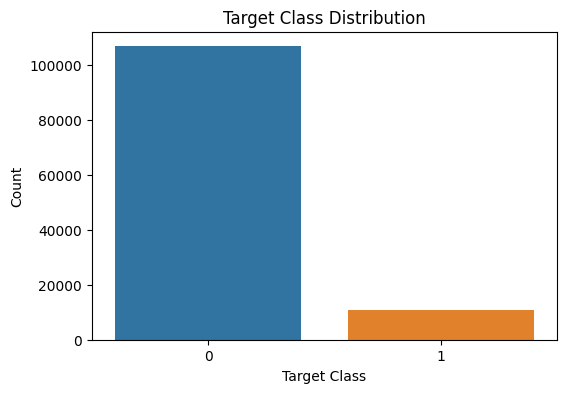

In [ ]:
# Bar plot for target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=pd.Series(y))
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Target Class Distribution')
plt.show()

<h1>Вывод</h1><b>По распределению целевой переменной наблюдается существенный дисбаланс</b>


<h1>Построим корреляционную матрицу</h1>

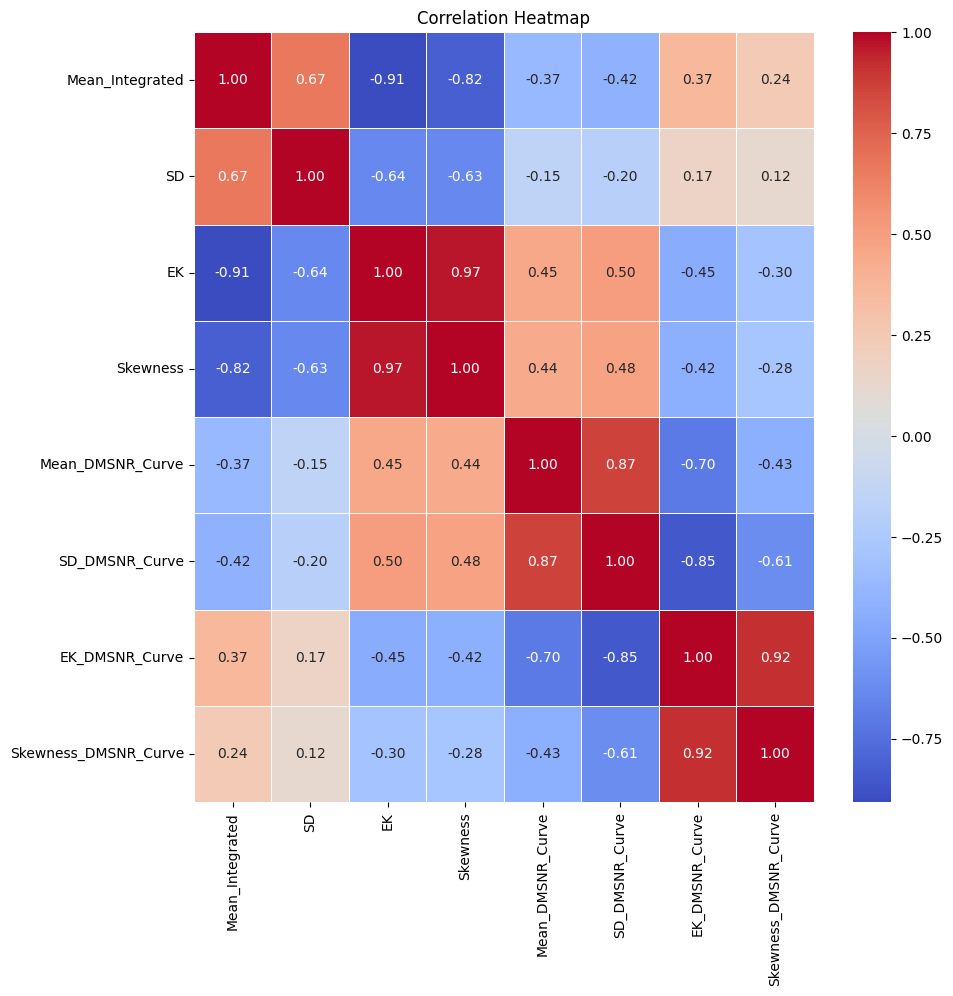

In [15]:
# Построим матрицу корреляций
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


<h1>Вывод</h1><b>Между некоторыми столбцами присутствует ярко выраженная линейная зависимость</b>

<h2>Разбиваем данные на train и test, сохраняем соотношение классов в обучающей и тестовой выборках</h2>

In [86]:
# Перекодировка
y_bin = y


In [87]:
np.random.seed(123)

# X = X[["sepal length (cm)", "sepal width (cm)"]]

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size=0.6, stratify=y_bin)

# Масштабировать признаки не будем
#ss = StandardScaler() # (x-m)/sigma

#X_train = ss.fit_transform(X_train)

#X_test = ss.transform(X_test)


<h1>А это функции для построения графиков</h1><b>(взято из ноутбука "Classification")</b>

In [18]:
# Функция для построения графиков решающих областей
def plot_decision_boundary(model, X, y):
    # Параметры для графика
    h = .02  # Шаг сетки
    cmap = plt.cm.RdYlBu
    markers = 's^o'  # Маркеры для классов

    # Обучение модели
    model.fit(X, y)

    # Размеры графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Предсказание значений на сетке
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Построение контуров
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)

    # Разметка классов
    for i, c in zip(range(2), markers):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], marker=c, label=f"Class {i}")

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions ({type(model).__name__})')
    plt.legend()
    plt.show()


In [19]:
# Функция для расчета метрик и построения кривой ROC
def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на обучающей и тестовой выборке
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Расчет метрик precision и recall
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)

    print(f"Training Precision: {train_precision:.2f}")
    print(f"Training Recall: {train_recall:.2f}")
    print(f"Test Precision: {test_precision:.2f}")
    print(f"Test Recall: {test_recall:.2f}")

    metrics =  {'params': ['Training_Precision', 'Test_Precision','Training_Recall', 'Test_Recall'],
                'values': [train_precision, test_precision, train_recall, test_recall]}

    # Расчет ROC-AUC на тестовой выборке
    try:
      pred_test = model.predict_proba(X_test)
      pred_train = model.predict_proba(X_train)
      roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
      roc_auc_train = roc_auc_score(y_train, pred_train[:, 1])
      print(f"ROC-AUC_test = : {roc_auc_test:.2f} и ROC-AUC_train = : {roc_auc_train:.2f}")

      # Построение кривой ROC
      fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
      fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
      plt.figure()
      plt.plot(fpr_test, tpr_test, color='blue', lw=2, label = 'ROC Curve test')
      plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label = 'ROC Curve test')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend()
      plt.title(f'ROC Curve ({type(model).__name__})')
      plt.show()
    except Exception as e:
      print(e)
    return metrics



<h1>А теперь построим и обучим модели</h1><b>Не будем пока ничего делать с выбросами и мультиколлинеарностью столбцов</b>

In [20]:
#фиксируем гсч
my_random_state = 12345


# Построим максимальное дерево

In [21]:
maxtree = DecisionTreeClassifier(random_state=my_random_state,
                                 max_depth=None)

In [22]:
maxtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=12345)

In [23]:
maxtree.score(X_train, y_train), maxtree.score(X_test, y_test)

(1.0, 0.9850720877812275)

#Видно что модель переобучилась

Training Precision: 1.00
Training Recall: 1.00
Test Precision: 0.92
Test Recall: 0.92
ROC-AUC_test = : 0.95 и ROC-AUC_train = : 1.00


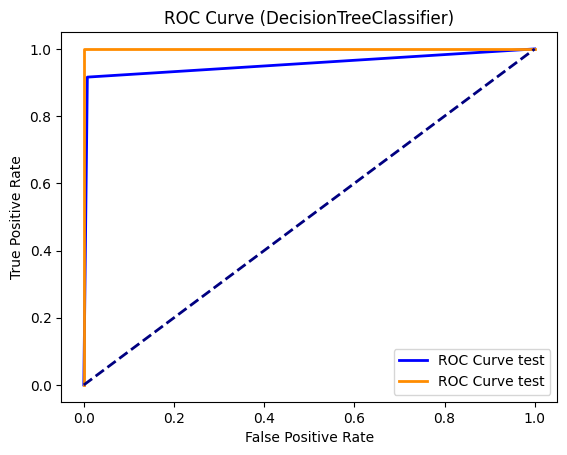

In [24]:
metrics_maxtree  = calculate_metrics_and_plot_roc(maxtree , X_train, y_train, X_test, y_test)

<h1>Строим модель бэггинга<br>

In [25]:
# Построение модели k-Nearest Neighbors (kNN)
bag = BaggingClassifier(estimator=maxtree,
                        n_estimators=100,
                        random_state=my_random_state,
                        max_samples=0.3)

In [26]:
bag.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=12345),
                  max_samples=0.3, n_estimators=100, random_state=12345)

In [27]:
bag.score(X_train, y_train), bag.score(X_test, y_test)

(0.9933794550455074, 0.9901118530174797)

#Это уже значительно лучше, чем максимальное дерево

Training Precision: 0.98
Training Recall: 0.95
Test Precision: 0.97
Test Recall: 0.92
ROC-AUC_test = : 0.99 и ROC-AUC_train = : 1.00


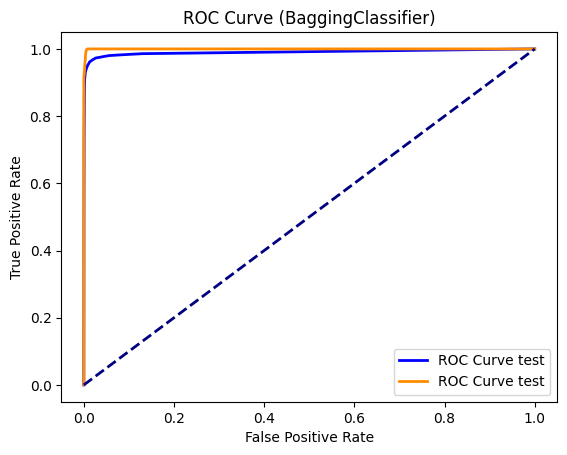

In [28]:
metrics_bag  = calculate_metrics_and_plot_roc(bag , X_train, y_train, X_test, y_test)

# Random Forest

In [29]:
rf = RandomForestClassifier(n_estimators=100,
                            random_state=my_random_state,
                            max_samples=0.3)

In [30]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.3, random_state=12345)

In [31]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9934078085570898, 0.9901118530174797)

#Найдем оптимальное количество эстиматоров

In [32]:
accuracy_dict = {}
for n in tqdm.tqdm(range(2, 200, 20), desc="Progress"):
  rf = RandomForestClassifier(n_estimators=n,
                              random_state=my_random_state,
                              max_samples=0.3)
  scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
  avg_accuracy = np.mean(scores)
  accuracy_dict[n] = avg_accuracy

Progress: 100%|██████████| 10/10 [04:19<00:00, 25.94s/it]


In [33]:
accuracy_dict

{2: 0.9870991491996977,
 22: 0.9909268863318503,
 42: 0.9908985296045018,
 62: 0.9911111869711238,
 82: 0.9911820757747467,
 102: 0.9911395416886402,
 122: 0.9911253693544634,
 142: 0.9911679044454862,
 162: 0.9911111970202866,
 182: 0.9911111980252029}

In [34]:
px.line(x=accuracy_dict.keys(), y=accuracy_dict.values(), labels={'y':'Accuarcy','x':'number of trees' })

#Оптимальное количество n_estimators=82

<b> Оцениваем точность на тестовой выборке, строим графики</b>

Training Precision: 0.98
Training Recall: 0.95
Test Precision: 0.97
Test Recall: 0.92
ROC-AUC_test = : 0.99 и ROC-AUC_train = : 1.00


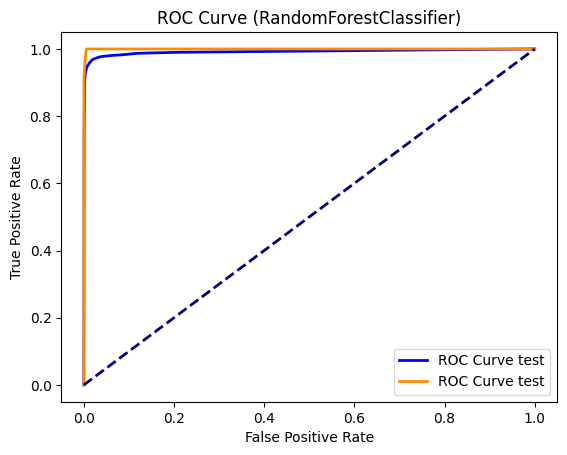

In [35]:
metrics_rf = calculate_metrics_and_plot_roc(rf, X_train, y_train, X_test, y_test)

<h1>Вывод</h1>
<b>Бэггинг на деревьях, и "Случайный лес" дали более высокие показатели точности по сравнению с моделью "DecisionTree"</b>


<h1>А теперь Бустинги</h1>
<b>.<br> </b>

##XGB

In [36]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.001)
# Fit the Model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
accuracy_score(y_test, np.round(xgb_model.predict(X_test))), accuracy_score(y_train, np.round(xgb_model.predict(X_train)))

(0.9897503508697316, 0.9910261135841674)

Training Precision: 0.97
Training Recall: 0.93
Test Precision: 0.97
Test Recall: 0.92
ROC-AUC_test = : 0.98 и ROC-AUC_train = : 0.98


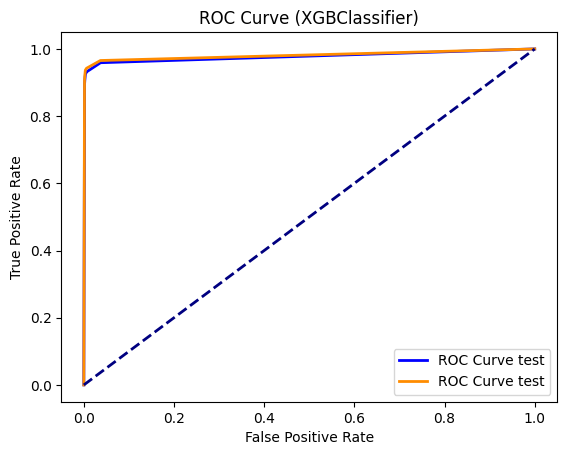

In [38]:
metrics_xgb = calculate_metrics_and_plot_roc(xgb_model, X_train, y_train, X_test, y_test)

<b>Да, похоже правду говорят - XGBoost не переобучается</b>

#catboost

In [41]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
# Создаем и обучаем модель CatBoost
model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss',verbose=False)
model_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# Предсказания на обучающей и тестовой выборке
y_train_pred = model_catboost.predict(X_train)
y_test_pred = model_catboost.predict(X_test)

# Оценка точности на обучающей и тестовой выборке
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.7f}")
print(f"Test Accuracy: {test_accuracy:.7f}")

Train Accuracy: 0.9918342
Test Accuracy: 0.9904521


Training Precision: 0.97
Training Recall: 0.94
Test Precision: 0.97
Test Recall: 0.93
ROC-AUC_test = : 0.99 и ROC-AUC_train = : 1.00


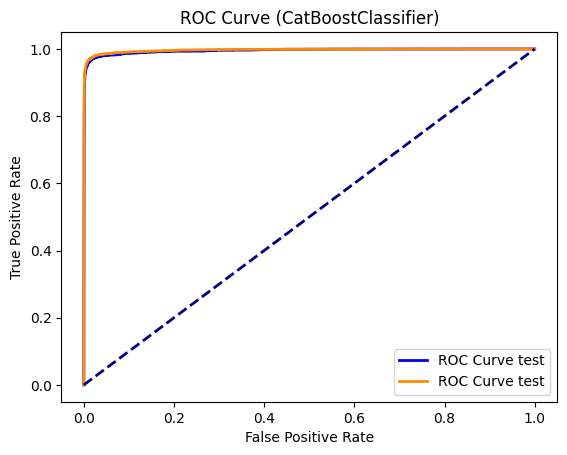

In [42]:
metrics_model_catboost = calculate_metrics_and_plot_roc(model_catboost, X_train, y_train, X_test, y_test)

<h1>Соберем все результаты в одну таблицу, чтобы было проще сравнивать алгоритмы

In [43]:
metrics_bag['metrics'] = ['metrics_bag' for i in range(4)]

metrics_rf['metrics'] = ['metrics_rf' for i in range(4)]

metrics_xgb['metrics'] = ['metrics_xgb' for i in range(4)]
metrics_model_catboost['metrics'] = ['metrics_model_catboost' for i in range(4)]

In [44]:
df_stat = pd.concat([pd.DataFrame(metrics_bag),
                    pd.DataFrame(metrics_rf),
                    pd.DataFrame(metrics_xgb),
                    pd.DataFrame(metrics_model_catboost)])

In [45]:
df_stat = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall']]
df_stat['dif_Precision'] = round((df_stat['Test_Precision'] - df_stat['Training_Precision'])/df_stat['Training_Precision'],2)

df_stat['dif_Recall'] = round((df_stat['Test_Recall'] - df_stat['Training_Recall'])/df_stat['Training_Recall'],2)
df_stat

params,metrics,Test_Precision,Training_Precision,Test_Recall,Training_Recall,dif_Precision,dif_Recall
0,metrics_bag,0.970489,0.980960,0.922042,0.947416,-0.01,-0.03
1,metrics_model_catboost,0.968810,0.972310,0.927513,0.939210,-0.00,-0.01
2,metrics_rf,0.970736,0.981881,0.922498,0.947112,-0.01,-0.03
3,metrics_xgb,0.966547,0.967899,0.922042,0.934802,-0.00,-0.01


<h1>Вывод</h1><br><b>Все четыре модели не плохо справились с классификацией пульсаров. <br>Наилучшую точность по Accuracy на тестовой выборке показал:<br> XGBoost (Test Accuracy:0.9910261135841674) <br>
Наилучшую точность по Test_Precision	показал Бэггинг на деревьях (Test_Precision:0.970489)<br>
Наилучшую точность по Test_Recall показал Catboost(Test_Recall: 0.927513)<br>
 Наименее переобученными оказались модели XGBoost и Catboost

 </b>
<h2>Таким образом в задаче по классификации пульсаров, победа достается методу XGBoost, как победившему в двух номинациях!</h2>

<h1>А теперь рассмотрим задачу регрессии</h1><br><b>В прошлой работе, где нужно было спрогнозировать цену домов  у меня получился немного парадоксальный результат - кодирование категориальных переменных привело к ухудшению точности прогноза.<br>
Сейчас хочу проверить это на Бустингах и Бэггингах<br>
Заодно постараюсь быть внимательнее, и не косячить.
</b>

Описание набора данных:
Набор данных, используемый для этого проекта, состоит из воображаемых данных, представляющих цены на жилье в городских районах Парижа. Каждая строка в наборе данных соответствует определенному дому, а столбцы представляют различные атрибуты, связанные с домами. Набор данных состоит исключительно из числовых переменных, что обеспечивает совместимость с методами регрессионного анализа. Включены следующие атрибуты:

Дана таблица в формате csv со следующими столбцами:<br>
<b>SquareMeters</b>: Общая площадь дома в квадратных метрах.<br>
<b>numberOfRooms</b>: количество комнат в доме.<br>
<b>hasYard</b>: двоичная переменная, указывающая, есть ли у дома двор (1) или нет (0).<br>
<b>hasPool</b>: двоичная переменная, указывающая, есть ли в доме бассейн (1) или нет (0).<br>
<b>floors</b>: Количество этажей в доме.<br>
<b>cityCode</b>: почтовый индекс расположения дома в Париже.<br>
<b>cityPartRange</b>: значение, указывающее на эксклюзивность района, причем более высокий диапазон указывает на более эксклюзивную область.<br>
<b>numPrevOwners</b>: количество предыдущих владельцев дома.<br>
<b>made</b>: Год постройки дома.<br>
<b>isNewBuilt</b>: двоичная переменная, указывающая, является ли дом новым (1) или нет (0).<br>
<b>hasStormProtector</b>: двоичная переменная, указывающая, есть ли в доме защита от шторма (1) или нет (0).<br>
<b>basement</b>: Площадь цокольного этажа в квадратных метрах.<br>
<b>atic</b>: Площадь чердака в квадратных метрах.<br>
<b>garage</b>: Размер гаража.<br>
<b>hasStorageRoom</b>: двоичная переменная, указывающая, есть ли в доме кладовая (1) или нет (0).<br>
<b>hasGuestRoom</b>: количество гостевых комнат в доме.<br>
<b>price</b>: прогнозируемая стоимость дома.<br>


<h1>Грузим датасет</h1>

In [46]:
#https://www.kaggle.com/competitions/playground-series-s3e6/data
# Читаем данные из файла
data = pd.read_csv('train_s3e6.csv')
data.tail(3)

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
22727,22727,93192,42,1,0,39,8539,10,5,2014,1,0,5595,4072,789,0,0,9321511.4
22728,22728,65797,86,1,0,89,23197,2,10,2000,1,0,5358,2513,411,0,0,6584708.2
22729,22729,82244,18,1,0,38,86728,1,9,2018,1,0,6294,1291,572,0,6,8231424.8


<h1>EDA</h1>

<b>Полный EDA для этого датасета находится в https://colab.research.google.com/drive/1YMeWslUibg9t6LUy67m9uCCvQihVkdzF#scrollTo=mjBuTK1Wj-9H</b>

<b>Здесь только напишу краткие выводы</b>
<h1>Общий вывод</h1>
<h2>В датасете Количество столбцов: 18
Количество строк: 22730 <br>
Объем памяти: 3.121612548828125 MB<br>
7 категориальных переменных, 10 числовых(включая id), и целевая переменная<br>
Пропущенных значений нет, выбросы есть, но мало<br>
Корреляционная матрица хорошенькая - ярко выраженной линейной зависимости между столбцами не наблюдается.  

<h2>Столбцам, которые по своей сути являются категориальными - определяем тип: "category" </h2>

In [47]:
df = data.drop(["id"],axis=1)
df = df.astype({"hasYard":"category","hasPool":"category","isNewBuilt":"category","hasStormProtector":"category","hasStorageRoom":"category","cityCode":"category","made":"category"})
df.dtypes

squareMeters            int64
numberOfRooms           int64
hasYard              category
hasPool              category
floors                  int64
cityCode             category
cityPartRange           int64
numPrevOwners           int64
made                 category
isNewBuilt           category
hasStormProtector    category
basement                int64
attic                   int64
garage                  int64
hasStorageRoom       category
hasGuestRoom            int64
price                 float64
dtype: object

<h2>создаем список для бинарных категориальных переменных </h2>

In [48]:
cat_cols = ["hasYard","hasPool","isNewBuilt","hasStormProtector","hasStorageRoom"]
cat_cols

['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']

<h2>создаем список для не бинарных категориальных переменных </h2>

In [49]:
cat_cols_not_bin = ["cityCode","made"]
cat_cols_not_bin

['cityCode', 'made']

<h2>создаем список для числовых переменных </h2>

In [50]:
num_cols = ['squareMeters', 'numberOfRooms', 'floors', 'cityPartRange', 'numPrevOwners', "basement", "attic", "garage", "hasGuestRoom"]
num_cols

['squareMeters',
 'numberOfRooms',
 'floors',
 'cityPartRange',
 'numPrevOwners',
 'basement',
 'attic',
 'garage',
 'hasGuestRoom']

<h1><b>Определяем роли переменных</b> </h1>

In [51]:
X = df.drop(columns=['price'])
y = df['price']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   squareMeters       22730 non-null  int64   
 1   numberOfRooms      22730 non-null  int64   
 2   hasYard            22730 non-null  category
 3   hasPool            22730 non-null  category
 4   floors             22730 non-null  int64   
 5   cityCode           22730 non-null  category
 6   cityPartRange      22730 non-null  int64   
 7   numPrevOwners      22730 non-null  int64   
 8   made               22730 non-null  category
 9   isNewBuilt         22730 non-null  category
 10  hasStormProtector  22730 non-null  category
 11  basement           22730 non-null  int64   
 12  attic              22730 non-null  int64   
 13  garage             22730 non-null  int64   
 14  hasStorageRoom     22730 non-null  category
 15  hasGuestRoom       22730 non-null  int64   
dtypes: c

<h1>Разбиваем данные на train и test</h1>

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.shape, X_test.shape

((18184, 16), (4546, 16))

In [54]:
X_train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
261,98350,31,0,1,87,28914,6,5,2000,1,0,5258,3454,218,0,3
4192,93409,82,1,1,64,54855,5,7,2018,1,1,793,8387,728,0,8
9698,60824,98,0,1,77,8528,4,10,1995,0,1,7728,8544,401,0,7
891,14322,33,0,1,66,91809,4,4,2017,0,0,8057,9057,208,0,5
20117,24633,13,0,1,49,10655,2,4,2016,1,1,6667,5610,990,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,40760,87,0,0,34,3812,2,9,2000,0,0,8787,422,307,0,4
21575,20075,20,1,1,85,14628,5,2,2010,0,0,5473,13,139,0,5
5390,72772,15,0,0,26,38639,9,3,2006,1,1,4304,8353,529,0,1
860,32060,56,0,1,38,68761,8,8,2007,1,0,4286,6867,805,1,8


In [55]:
y_train

261      9843345.2
4192     9341198.0
9698     6086663.5
891      1439924.7
20117    2473370.6
           ...    
11964    4080383.1
21575    2010227.0
5390     7280658.6
860      3211741.7
15795    4510977.7
Name: price, Length: 18184, dtype: float64

<h1> Выделяем числовые признаки, не масштабируем </h1>

In [56]:
X_train_num = X_train[num_cols].copy()

X_test_num = X_test[num_cols].copy()


<h1>Применяем к бинарным категориальным переменным One-Hot Encoding</h1>

In [57]:
X_train_dum = pd.get_dummies(X_train[cat_cols], columns=cat_cols)
X_test_dum = pd.get_dummies(X_test[cat_cols], columns=cat_cols)

In [58]:
X_train_dum

,hasYard_0,hasYard_1,hasPool_0,hasPool_1,isNewBuilt_0,isNewBuilt_1,hasStormProtector_0,hasStormProtector_1,hasStorageRoom_0,hasStorageRoom_1
261,1,0,0,1,0,1,1,0,1,0
4192,0,1,0,1,0,1,0,1,1,0
9698,1,0,0,1,1,0,0,1,1,0
891,1,0,0,1,1,0,1,0,1,0
20117,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
11964,1,0,1,0,1,0,1,0,1,0
21575,0,1,0,1,1,0,1,0,1,0
5390,1,0,1,0,0,1,0,1,1,0
860,1,0,0,1,0,1,1,0,0,1


In [59]:
X_test_dum

,hasYard_0,hasYard_1,hasPool_0,hasPool_1,isNewBuilt_0,isNewBuilt_1,hasStormProtector_0,hasStormProtector_1,hasStorageRoom_0,hasStorageRoom_1
1087,0,1,1,0,1,0,0,1,1,0
6377,0,1,0,1,1,0,1,0,1,0
4153,1,0,1,0,0,1,1,0,0,1
19452,1,0,1,0,1,0,0,1,0,1
10043,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
17711,0,1,0,1,1,0,1,0,0,1
10331,1,0,1,0,1,0,0,1,0,1
14600,1,0,1,0,0,1,1,0,1,0
20785,1,0,1,0,1,0,1,0,0,1


<h1>К не бинарным категориальным переменным применяем frequence encoding</h1>

In [60]:
# Создадим новый DataFrame
encoded_X_train = pd.DataFrame()
encoded_X_test = pd.DataFrame()
# Создаем словарь для хранения частот категорий
freq_dict = {}

# Вычисляем частоты категорий в каждом столбце и сохраняем в словарь
for col in cat_cols_not_bin:
    freq_dict[col] = X_train[col].value_counts(normalize=True)

# Проходимся по каждому столбцу и заменяем категории их частотными значениями
for col in cat_cols_not_bin:
    encoded_X_train[col + '_freq_encode'] = X_train[col].map(freq_dict[col])
    encoded_X_test[col + '_freq_encode'] = X_test[col].map(freq_dict[col])


In [61]:
encoded_X_train

,cityCode_freq_encode,made_freq_encode
261,0.000110,0.156071
4192,0.000275,0.039540
9698,0.000165,0.028982
891,0.000495,0.032171
20117,0.000605,0.040090
...,...,...
11964,0.000110,0.156071
21575,0.000330,0.006819
5390,0.000055,0.040695
860,0.000165,0.044820


In [62]:
encoded_X_test

,cityCode_freq_encode,made_freq_encode
1087,0.000165,0.045755
6377,0.000055,0.032171
4153,0.000550,0.040695
19452,0.000275,0.025242
10043,0.000110,0.052464
...,...,...
17711,0.000165,0.028047
10331,0.000275,0.034701
14600,0.000220,0.156071
20785,0.000715,0.041025


# Объединяем закодированные категориальные и  числовые переменные и посмотрим на то, что получилось, перед построением моделей

In [63]:
dfs_train = [X_train_num,
             encoded_X_train,
             X_train_dum]

In [64]:
df_train = pd.concat(dfs_train, axis=1)

In [65]:
df_train.shape

(18184, 21)

In [66]:
df_train.head()

,squareMeters,numberOfRooms,floors,cityPartRange,numPrevOwners,basement,attic,garage,hasGuestRoom,cityCode_freq_encode,...,hasYard_0,hasYard_1,hasPool_0,hasPool_1,isNewBuilt_0,isNewBuilt_1,hasStormProtector_0,hasStormProtector_1,hasStorageRoom_0,hasStorageRoom_1
261,98350,31,87,6,5,5258,3454,218,3,0.000110,...,1,0,0,1,0,1,1,0,1,0
4192,93409,82,64,5,7,793,8387,728,8,0.000275,...,0,1,0,1,0,1,0,1,1,0
9698,60824,98,77,4,10,7728,8544,401,7,0.000165,...,1,0,0,1,1,0,0,1,1,0
891,14322,33,66,4,4,8057,9057,208,5,0.000495,...,1,0,0,1,1,0,1,0,1,0
20117,24633,13,49,2,4,6667,5610,990,3,0.000605,...,1,0,0,1,0,1,0,1,0,1


In [67]:
dfs_test = [X_test_num,
             encoded_X_test,
             X_test_dum]

In [68]:
df_test = pd.concat(dfs_test, axis=1)

In [69]:
df_test.shape

(4546, 21)

In [70]:
df_test.head()

,squareMeters,numberOfRooms,floors,cityPartRange,numPrevOwners,basement,attic,garage,hasGuestRoom,cityCode_freq_encode,...,hasYard_0,hasYard_1,hasPool_0,hasPool_1,isNewBuilt_0,isNewBuilt_1,hasStormProtector_0,hasStormProtector_1,hasStorageRoom_0,hasStorageRoom_1
1087,50673,9,67,3,3,3836,9274,192,6,0.000165,...,0,1,1,0,1,0,0,1,1,0
6377,75848,26,17,9,2,6974,771,431,7,0.000055,...,0,1,0,1,1,0,1,0,1,0
4153,89637,48,80,4,8,5481,2516,112,4,0.000550,...,1,0,1,0,0,1,1,0,0,1
19452,71824,10,50,7,1,4901,3635,313,0,0.000275,...,1,0,1,0,1,0,0,1,0,1
10043,99886,46,32,4,9,4516,7789,241,2,0.000110,...,1,0,0,1,0,1,0,1,1,0


#Посмотрим еще раз на не обработанную тренировочную выборку. Вроде всё норм. Ничего не запортила.

In [71]:
X_train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
261,98350,31,0,1,87,28914,6,5,2000,1,0,5258,3454,218,0,3
4192,93409,82,1,1,64,54855,5,7,2018,1,1,793,8387,728,0,8
9698,60824,98,0,1,77,8528,4,10,1995,0,1,7728,8544,401,0,7
891,14322,33,0,1,66,91809,4,4,2017,0,0,8057,9057,208,0,5
20117,24633,13,0,1,49,10655,2,4,2016,1,1,6667,5610,990,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,40760,87,0,0,34,3812,2,9,2000,0,0,8787,422,307,0,4
21575,20075,20,1,1,85,14628,5,2,2010,0,0,5473,13,139,0,5
5390,72772,15,0,0,26,38639,9,3,2006,1,1,4304,8353,529,0,1
860,32060,56,0,1,38,68761,8,8,2007,1,0,4286,6867,805,1,8


#А теперь Бустинги!

#catboost

In [72]:
# Импорт необходимых библиотек
import catboost as cb
from sklearn.metrics import mean_squared_error

# Создание модели Catboost
model = cb.CatBoostRegressor(verbose=False)

# Обучение модели на обучающей выборке
model.fit(df_train, y_train)

# Предсказание на обучающей и тестовой выборке
train_predictions = model.predict(df_train)
test_predictions = model.predict(df_test)

# Оценка точности модели с помощью RMSE
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 67393.54957802304
Test RMSE: 176967.50559335988


##XGB

In [73]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Создание объекта модели XGBoost
model = xgb.XGBRegressor()

# Обучение модели на обучающей выборке
model.fit(df_train, y_train)

# Предсказание на обучающей и тестовой выборке
train_predictions = model.predict(df_train)
test_predictions = model.predict(df_test)

# Оценка точности модели с помощью RMSE
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 16985.263559596027
Test RMSE: 201710.31135882362


<b> Ну, вот. Бустинги смогли отработать только на обработанных данных (с закодированными категориальными переменными)</b><br>
<b> На не обработанных данных оба метода просто упали.</b>

#А ДЕРЕВЬЯМ ПОХОЖЕ - ВСЕ ФИОЛЕТОВО!

#Random Forest на не обработанных данных (просто разбили на train и test)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Создание объекта модели Random Forest
model = RandomForestRegressor()

# Обучение модели на обучающей выборке
model.fit(X_train, y_train)

# Предсказание на обучающей и тестовой выборке
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Оценка точности модели с помощью RMSE
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 67391.06357205023
Test RMSE: 204983.6488095378


#Random Forest на  обработанных данных (категориальные переменные закодированы)

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Создание объекта модели Random Forest
model = RandomForestRegressor()

# Обучение модели на обучающей выборке
model.fit(df_train, y_train)

# Предсказание на обучающей и тестовой выборке
train_predictions = model.predict(df_train)
test_predictions = model.predict(df_test)

# Оценка точности модели с помощью RMSE
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 68227.94082321285
Test RMSE: 212045.48234469333


<h1>Вывод</h1><br><b>Да что же это такое с деревьями? <br>Деревья лучше работают на никак не обработанных данных! </b><br>
<b>Возможно, это так только на этом датасете... Но, все таки!</b><br>
<b>А по точности снова победили Бустинги</b><br>
<b>catboost оказался точнее остальных (Test RMSE: 176967.50559335988)</b><br>